In [1]:
import numpy as np
from numpy.linalg import norm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
raw_dataset_file = "datasets/global_dataset.txt"
clean_dataset_file = "datasets/global_datasetMin.txt"

In [3]:
with open(clean_dataset_file, "r") as f:
    clean_dataset = f.read().splitlines()

In [4]:
from gensim.models import KeyedVectors

model = KeyedVectors.load("models/w2vec_model_d300_global_Min")
dim = 300

def encode(msg, model, dim):
    return np.mean([model[word] for word in msg if word in model] or [np.zeros(dim)], axis = 0)

In [5]:
%%time
#encodage de l'échantillon pour créer le jeu de données
dataset_encoded = np.array([encode(msg, model, dim) for msg in clean_dataset])

CPU times: user 1min 57s, sys: 493 ms, total: 1min 58s
Wall time: 1min 58s


In [6]:
dataset_train, dataset_test = train_test_split(dataset_encoded, test_size=0.2)

### Modèle

In [80]:
inputs = keras.Input(shape=(300,))
#encoded = keras.layers.Dense(2, activation="relu")(inputs)
encoded = keras.layers.Dense(2)(inputs)
decoded = keras.layers.Dense(300, activation="tanh")(encoded)

encoder = keras.Model(inputs, encoded, name="encoder")
#decoder = keras.Model(inputs, 
autoencoder = keras.Model(inputs, decoded, name="autoencoder")

In [81]:
#encoded_inputs = keras.Input(shape=(2,))
#decoder = keras.Model(encoded_inputs, autoencoder.layers[-1](encoded_inputs), name="decoder")

In [82]:
autoencoder.compile(optimizer='adam', loss='mse')

### Entraînement

In [84]:
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath="models/ae_Min_model_norelu", verbose=0, save_best_only=True)

In [85]:
autoencoder.fit(dataset_train, dataset_train,
                epochs=30,
                batch_size=256,
                shuffle=True,
                validation_data=(dataset_test, dataset_test),
                callbacks=[savemodel_callback])

Epoch 1/30
2248/2248 [==============================] - 6s 2ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 2/30
2248/2248 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 3/30
2248/2248 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/30
2248/2248 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 5/30
2248/2248 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/30
2248/2248 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 7/30
2248/2248 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/30
2248/2248 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 9/30
2248/2248 [==============================] - 5s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/30
2248/2248 [==============================] - 5s 2ms/step - loss: 0.001

In [78]:
import gc

In [79]:
inputs = None
encoded = None
decoded = None
savemodel_callback = None
encoder = None
decoder = None 
encoded_inputs = None
autoencoder = None
gc.collect()

30788

In [89]:
def cosine_similarity(a, b):
    return np.dot(a,b)/(norm(a)*norm(b))

In [90]:
n = 42
cosine_similarity(autoencoder.predict(dataset_encoded[n:n+1]), dataset_encoded[n])

array([0.99604965])

In [91]:
autoencoder.predict(dataset_encoded[n:n+1])[0,:10]

array([ 0.1642095 ,  0.46606317,  0.3016118 ,  0.1084001 ,  0.16047715,
        0.04377633, -0.20398284,  0.32670182, -0.11586265, -0.23260158],
      dtype=float32)

In [92]:
dataset_encoded[n,:10]

array([ 0.17151119,  0.49289277,  0.29393384,  0.08964436,  0.16869645,
        0.03951823, -0.19311355,  0.32082355, -0.12117271, -0.25077292])

### Visualisation du dataset ainsi encodé en deux dimensions

In [93]:
%%time
two_dim_dataset = encoder.predict(dataset_encoded)

CPU times: user 20 s, sys: 2.38 s, total: 22.4 s
Wall time: 14.1 s


In [94]:
b = two_dim_dataset.T

In [95]:
import matplotlib.pyplot as plt

In [96]:
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["lines.markersize"] = 3
plt.rcParams["scatter.marker"] = '.'

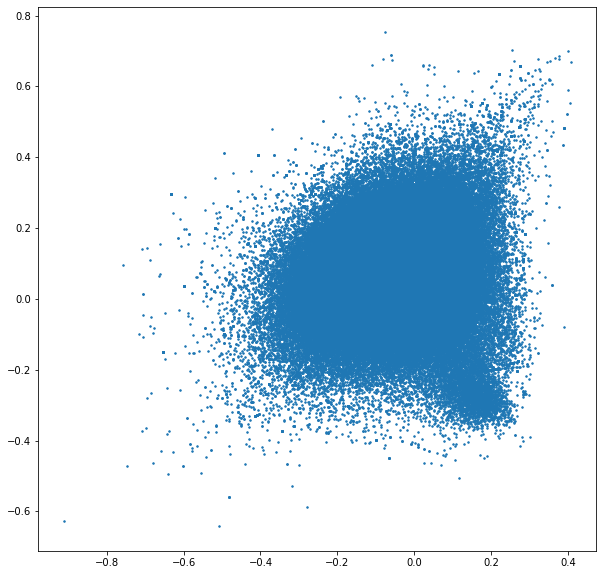

In [97]:
plt.scatter(b[0], b[1])
plt.show()

### Comparaison avec PCA

In [71]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [72]:
%%time
#On crée une version en deux dimensions de notre jeu de données
pca_two_dim_dataset = pca.fit_transform(dataset_encoded)

CPU times: user 46.2 s, sys: 14.4 s, total: 1min
Wall time: 11.8 s


In [76]:
pca = pca_two_dim_dataset.T

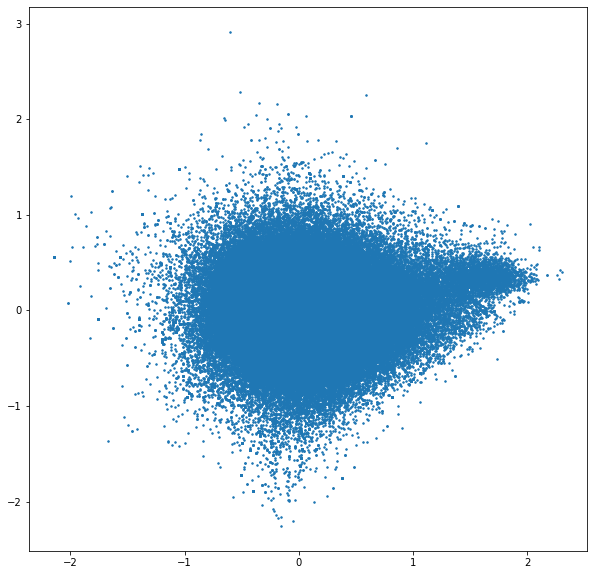

In [77]:
plt.scatter(pca[0], pca[1])
plt.show()